## Data analysis

In [1]:
from utils import *
import torch
import numpy as np
import pandas as pd
from scipy.stats import f
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

2023-01-03 18:14:14.247514: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-03 18:14:14.247560: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [3]:
def show_images(data, n_samples):

    plt.figure(figsize=(8,2))

    for i in range(n_samples):
        image = data[i][0].reshape(8, 8)
        plt.subplot(1,n_samples,i+1)
        plt.axis('off')
        plt.imshow(image.numpy(), cmap='gray')
        
    plt.show()

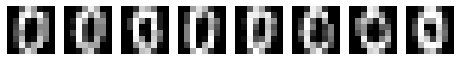

178

In [4]:
# Showing real data

digits = datasets.load_digits()

x_train = digits.data
y_train = digits.target

x_train = x_train.reshape(len(x_train), 8, 8)
x_train.shape

rd, real_data = resize_data(x_train, y_train, label = (0,), image_size = 8)
show_images(rd, 8)
len(rd)

In [5]:
dataloader = torch.utils.data.DataLoader(rd, batch_size=1, shuffle=True, drop_last=True)

# for elem in dataloader:
#     plt.imshow(elem[0][0])

ValueError: cannot reshape array of size 32 into shape (8,8)

<Figure size 432x288 with 0 Axes>

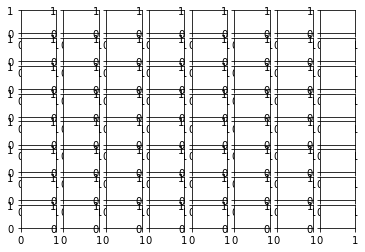

In [6]:
# Making inference with classical GAN

model = torch.load('torch_results/GAN/GAN_linear/20230103-180533/lin_gen_epoch_2')   # '0' features

#model.eval()

#GAN_imgs = []

# noise_dim = 5

# for i in range(len(real_data)):      
     
#     image = model(torch.rand(1, noise_dim)).view(1,8,8).cpu().detach()
#     GAN_imgs.append(image)

# show_images(GAN_imgs, 8), GAN_imgs[0].shape


noise_dim = 5

plt.figure()
f, axarr = plt.subplots(8, 8) 
for i, ax in enumerate(axarr.ravel()):
    ax.imshow(model(torch.rand(1,noise_dim)).detach().numpy().reshape(8,8), cmap = 'gray')
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
f.tight_layout()
plt.show()
# plt.figure()
# f, axarr = plt.subplots(8, 8) 
# for i, ax in enumerate(axarr.ravel()):
#     ax.imshow(model(torch.rand(1,noise_dim)).detach().numpy().reshape(8,8), cmap = 'gray')
#     ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
# f.tight_layout()
# plt.show()

In [7]:
model, model(torch.rand(1,noise_dim)).shape

(Generator(
   (dense_layer): Linear(in_features=5, out_features=32, bias=True)
   (relu): LeakyReLU(negative_slope=0.01)
   (lin): Linear(in_features=32, out_features=64, bias=True)
   (activation): Sigmoid()
 ),
 torch.Size([1, 32]))

In [ ]:
len(GAN_imgs)

In [ ]:
synthetic = torch.load('torch_results/GAN/GAN_linear/20221229-112146/synthetic.pt')
#generated_images(synthetic)
show_images(synthetic[:28], 8)

In [ ]:
# Making inference with QGAN

#q_model = torch.load('torch_results/QGAN/QGAN_linear/20221216-184033/q_gen_epoch_500')  # '0' features 6 layers
#q_model = torch.load('torch_results/QGAN/QGAN_linear/20221228-162657/lin_q_gen_epoch_500')  # '0' features 6 layers new vqc
q_model = torch.load('torch_results/QGAN/QGAN_linear/20221228-173805/lin_q_gen_epoch_1400')  # '0' '1' features 6 layers new vqc
#q_model = torch.load('torch_results/QGAN/QGAN_linear/20221228-141802/lin_q_gen_epoch_510')  # '0' features 6 Random layers
#q_model = torch.load('torch_results/QGAN/QGAN_linear/20221219-093229/q_gen_epoch_1500')  # '0','1' features 6 layers
#q_model = torch.load('torch_results/QGAN/QGAN_linear/20221216-125209/q_gen_epoch_1000')  # '0','1' features 8 layers
#q_model = torch.load('torch_results/QGAN/QGAN_linear/20221216-150017/q_gen_epoch_2000')  # '0','1' features 10 layers
#q_model = torch.load('torch_results/QGAN/QGAN_linear/20221216-112234/q_gen_epoch_2000')  # '0','1','2' features
q_model.eval()

QGAN_imgs = []
for i in range(len(real_data)):      
    fixed_noise = torch.rand(1, 5)  
    q_image = q_model(fixed_noise).view(1,8,8).cpu().detach()
    QGAN_imgs.append(q_image)

show_images(QGAN_imgs, 8)

In [ ]:
q_synthetic = torch.load('torch_results/QGAN/QGAN_linear/20221228-173805/synthetic.pt')  
#generated_images(q_synthetic)
show_images(q_synthetic[:20], 8), len(q_synthetic)

In [ ]:
# Plotting histogram probability distributions 

linear_gan_synthetic = np.concatenate(GAN_imgs).reshape(len(GAN_imgs), 8, 8)
reshaped_linear_gan_synthetic = linear_gan_synthetic.reshape(len(GAN_imgs)*64)
linear_qgan_synthetic = np.concatenate(QGAN_imgs).reshape(len(QGAN_imgs), 8, 8)
reshaped_linear_qgan_synthetic = linear_qgan_synthetic.reshape(len(QGAN_imgs)*64)
real_data = np.concatenate(real_data).reshape(len(real_data), 8, 8)
reshaped_real_data = real_data.reshape(len(real_data)*64)

empty_dataframe = pd.DataFrame(columns=['Real data','GAN', 'QGAN'])
df1 = pd.DataFrame(reshaped_real_data)
df2 = pd.DataFrame(reshaped_linear_gan_synthetic)
df3 = pd.DataFrame(reshaped_linear_qgan_synthetic)
df = pd.concat([df1, df2, df3], 1)
df.columns = ['Real data','GAN', 'QGAN']

sns.displot(data = df, kind = 'kde')